In [1]:
import os
import re
import tqdm
import string
import pandas as pd
import numpy as np
import util
from sklearn.decomposition import TruncatedSVD
from data_preprocessing import *
import word_embedding_load as wel
from classification import *
from xgboost_classifier import *
from testaccuracy import *

C:\Users\zhuya\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.
C:\Users\zhuya\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
[all_data, train_size, test_size, train_x, train_y, test_x] = util.loadData()
sentences = data_preprocess(all_data)

In [3]:
Text_INPUT_DIM=200
GENE_INPUT_DIM=25
TEXT_INPUT_DIM=200
PATH = '../model/doc2vec/'
modelName='docEmbeddings_win30_load_all.d2v'

In [4]:
param = util.Doc2VecParam(1, 2, 200, 1e-4, 5, 4, 30, 1)

In [5]:
svd = TruncatedSVD(n_components=GENE_INPUT_DIM, n_iter=25, random_state=12)

In [6]:
#load a pre-trained text model
text_model = wel.loadTextModel(PATH + modelName)

#To train a new text model, default without outside data:
#text_model = wel.trainTextModel(sentences, param, 'newModelName', PATH)

#To train a new text model with outside data:
#sourceFile = '../data/bio_nlp_vec/PubMed-shuffle-win-30.bin'
#text_model = wel.trainTextModel(sentences, param, 'newModelName', PATH, True, sourceFile)

Successfully loaded the textmodel from ../model/doc2vec/docEmbeddings_win30_load_all.d2v


In [7]:
truncated_one_hot_gene = wel.getGeneVec(all_data, svd)
truncated_one_hot_variation = wel.getVariationVec(all_data, svd)
text_train_arrays, text_test_arrays = wel.getTextVec(text_model, train_size, test_size, TEXT_INPUT_DIM)

In [8]:
print(text_train_arrays.shape)
print(text_test_arrays.shape)
text_train_arrays[0]

(3689, 200)
(986, 200)


array([  1.26882315,   4.29688072,  -0.39038292,  -1.35480559,
        -7.99099302,   4.77952766,   2.07057571,  -6.03570271,
         0.86446071,   0.17202322,  -2.32006383,  -5.02870607,
         6.17888403,  -0.33701557,  -1.9275701 ,  -4.0776453 ,
        -0.09364942,  -2.15795469,   6.18154764,  -0.85709518,
         3.39536762,  -2.35704374,   2.01819372,   2.00250816,
        -2.80324435,  -1.02548444,  -8.66605091,  -4.82370663,
         1.46748042,  -1.77919805,   3.44936085,   1.01866448,
        -2.25563884,   5.47780323,  -3.01734948,  -4.96943665,
         5.47637558,   6.81975794,  -6.858356  ,   4.44475985,
         5.04804468,   1.93569362,  -1.02952111,   4.82035208,
         4.84539604,   1.75127947,  -2.98756957,   2.69090438,
         3.09679723,  -1.40729642,  -2.39587927,  -3.08425999,
        -4.78242826,   0.60178131,  -1.22717583,   1.39289582,
         3.20111299,  -3.3035841 ,  -1.39491498,  -0.63641626,
         5.13298321,   3.72240472,  -7.51442385,   1.85

In [9]:
train_set = np.hstack((truncated_one_hot_gene[:train_size], truncated_one_hot_variation[:train_size], text_train_arrays))
test_set = np.hstack((truncated_one_hot_gene[train_size:], truncated_one_hot_variation[train_size:], text_test_arrays))
encoded_y = pd.get_dummies(train_y)
encoded_y = np.array(encoded_y)
print(encoded_y.shape)

(3689, 9)


In [10]:
print(train_set.shape)
print(test_set.shape)
train_set[0, 25:50]

(3689, 250)
(986, 250)


array([  1.00000000e+00,   4.18523246e-19,   1.82140582e-19,
         5.52932734e-29,   9.01317672e-25,   1.47967745e-22,
        -8.38240178e-21,   2.00300590e-21,   9.74158370e-21,
        -9.34683441e-21,   1.91083889e-20,   6.55003880e-19,
        -1.09276438e-17,  -1.56730196e-18,  -2.12913704e-18,
        -4.51096312e-18,  -3.82900024e-19,   1.15894157e-17,
         1.59938703e-17,   3.58735292e-17,  -3.35304994e-18,
         1.68462844e-17,   6.76851697e-18,   5.86047343e-17,
         7.80129580e-21])

In [11]:
#the xgboost classfication model
#first deal with the input label, transfrom it from 1-9 to 0-8(required by the xgboost)
for i in range(len(train_y)):
    train_y[i] -=1  

[0]	train-mlogloss:2.11739	valid-mlogloss:2.1377
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[25]	train-mlogloss:1.0666	valid-mlogloss:1.42621
[50]	train-mlogloss:0.629127	valid-mlogloss:1.17486
[75]	train-mlogloss:0.394962	valid-mlogloss:1.059
[100]	train-mlogloss:0.262461	valid-mlogloss:1.00856
[125]	train-mlogloss:0.18144	valid-mlogloss:0.9899
[150]	train-mlogloss:0.129314	valid-mlogloss:0.982268
[175]	train-mlogloss:0.092984	valid-mlogloss:0.982589
[200]	train-mlogloss:0.068722	valid-mlogloss:0.986811
[225]	train-mlogloss:0.052683	valid-mlogloss:0.994001
[250]	train-mlogloss:0.041477	valid-mlogloss:1.00315
Stopping. Best iteration:
[158]	train-mlogloss:0.116016	valid-mlogloss:0.98189

final validation loss:
0.98189047508
final validation accuracy:
0.658536585366
[0]	train-mlogloss:2.12019	valid-mlogloss:2.1408
Multiple eval metrics have been passed: 'valid-mlogloss' will be

[275]	train-mlogloss:0.034341	valid-mlogloss:0.875786
Stopping. Best iteration:
[198]	train-mlogloss:0.071312	valid-mlogloss:0.866032

final validation loss:
0.866031590758
final validation accuracy:
0.682926829268
[0]	train-mlogloss:2.11902	valid-mlogloss:2.14278
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[25]	train-mlogloss:1.08314	valid-mlogloss:1.48533
[50]	train-mlogloss:0.628049	valid-mlogloss:1.23945
[75]	train-mlogloss:0.389495	valid-mlogloss:1.12241
[100]	train-mlogloss:0.25542	valid-mlogloss:1.07188
[125]	train-mlogloss:0.176232	valid-mlogloss:1.05239
[150]	train-mlogloss:0.126066	valid-mlogloss:1.04494
[175]	train-mlogloss:0.092964	valid-mlogloss:1.04477
[200]	train-mlogloss:0.069353	valid-mlogloss:1.04915
[225]	train-mlogloss:0.053213	valid-mlogloss:1.05658
[250]	train-mlogloss:0.042004	valid-mlogloss:1.06862
Stopping. Best iteration:
[167]	train-mlogloss:0.102218	

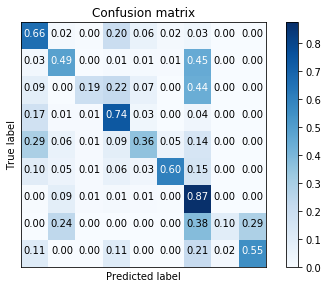

In [12]:
y_predict = xgbclassifier(train_set, train_y, test_set, 10, 8, 1000)

In [13]:
savesubmisstion(y_predict, test_x, filename = "submission_allwin2load30fold.csv")